# Modeling Extremes - Scipy

In this example, we will look at how we can use the `scipy` library to learn relevan distributions for extreme values, i.e., GEVD.

In [4]:
import autoroot
import pandas as pd
from scipy.stats import rv_histogram, genextreme
import numpy as np
import xarray as xr
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [5]:
from bayesevt._src.data.local import DATASET_SPAIN_DAILY

ds = xr.open_mfdataset(DATASET_SPAIN_DAILY["t2max"])

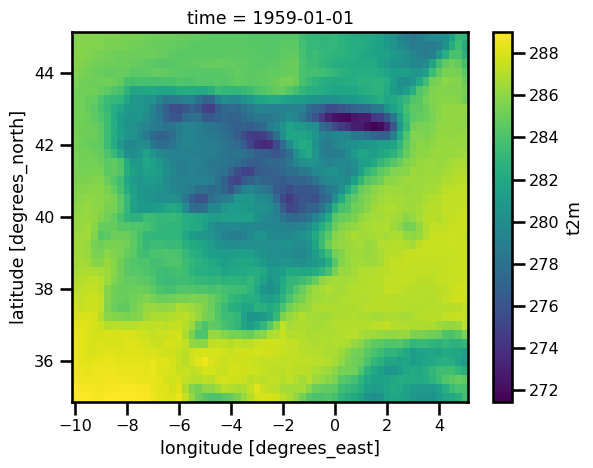

In [6]:
ds.t2m.isel(time=0).plot.pcolormesh()

In [7]:
ds.t2m.latitude.min(), ds.t2m.latitude.max()

(<xarray.DataArray 'latitude' ()> Size: 8B
 array(35.),
 <xarray.DataArray 'latitude' ()> Size: 8B
 array(45.))

## Masking

In [8]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [9]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

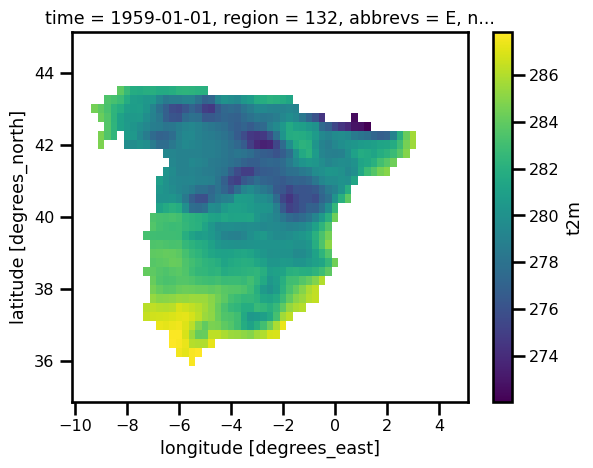

In [10]:

ds.where(ds.spain_mask==1).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [11]:
ds.longitude

<xarray.DataArray 'longitude' (longitude: 61)> Size: 244B
array([-10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,  -8.  ,
        -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,  -6.  ,  -5.75,
        -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,  -4.  ,  -3.75,  -3.5 ,
        -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,  -2.  ,  -1.75,  -1.5 ,  -1.25,
        -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,   0.25,   0.5 ,   0.75,   1.  ,
         1.25,   1.5 ,   1.75,   2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,
         3.5 ,   3.75,   4.  ,   4.25,   4.5 ,   4.75,   5.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 244B -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0
    region     int64 8B 132
    abbrevs    <U2 8B 'E'
    names      <U8 32B 'Spain'
Attributes:
    units:      degrees_east
    long_name:  longitude

In [12]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [25]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [26]:

# convert Kelvin to Celcius
data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        20.908280
std          8.781399
min          0.399664
25%         13.378348
50%         19.651903
75%         28.521552
max         41.903027
Name: t2m, dtype: float64

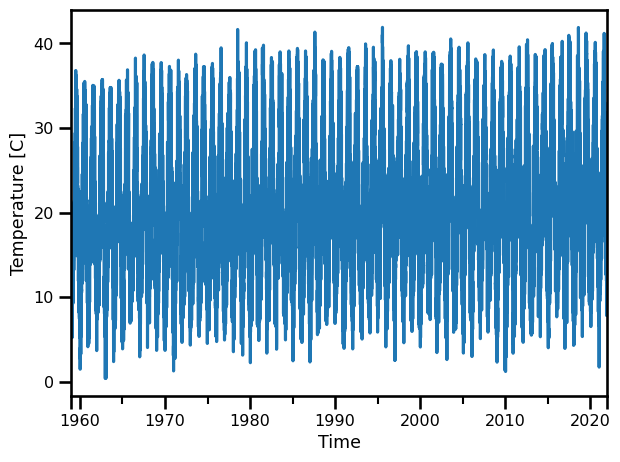

In [27]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [28]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

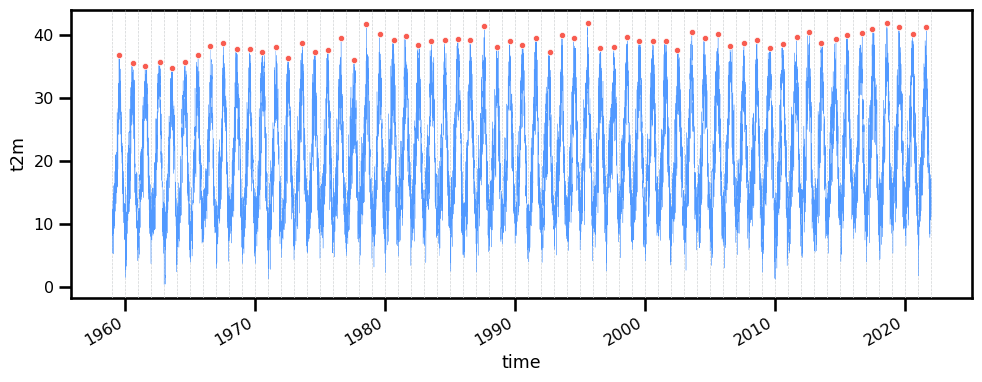

In [29]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We will use the GEVD as our model.
The `scipy.stats` library has a `genextreme` distribution which has all of the functionality we need.
It also has built-in method to learn the parameters using the MLE method.

**Resources**:
* Scipy GEV - [scipy docs]()
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [30]:
# fit parameters to data
params = genextreme.fit(extremes, method="MLE")
model = genextreme(*params)
print("Parameters (MLE):")
print(f"Shape - ξ: {params[0]:.4f}")
print(f"Loc   - μ: {params[1]:.4f}")
print(f"Scale - σ: {params[2]:.4f}")

Parameters (MLE):
Shape - ξ: 0.4002
Loc   - μ: 38.2624
Scale - σ: 1.7326


## Diagnostics: Goodness of Fit

**Null Hypothesis**: *The distribution of the independent samples is identical to the specified cumulative distribution*.

If the statistic is small or the p-value is high, then we accept the null hypothesis.

In [31]:
from scipy.stats import kstest

In [32]:
out = kstest(extremes, model.cdf)
print(f"Kolmogorov-Smirnov Test")
print(f"Statistic: {out.statistic:.4f}")
print(f"P-Value: {out.pvalue:.4f}")

Kolmogorov-Smirnov Test
Statistic: 0.0578
P-Value: 0.9765


We **accept** the null hypothesis.

### Viz I: CDF

In [33]:
# create a length of the domain
x_domain = np.linspace(extremes.min(), extremes.max(), 100)
# get the PDF of the distribution
y_pdf = genextreme.pdf(x_domain, *params)

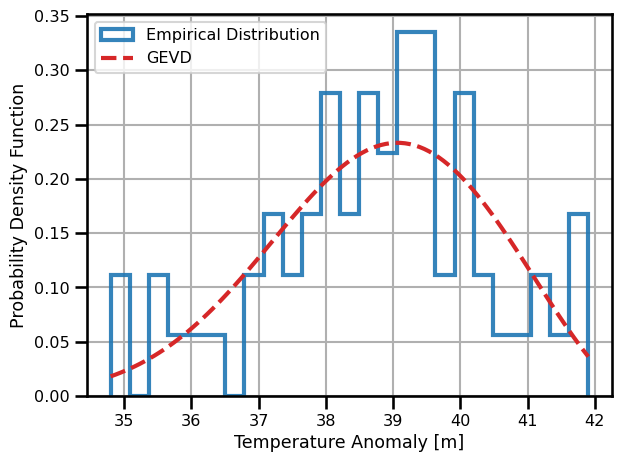

In [34]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=False, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_pdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Temperature Anomaly [m]",
    ylabel="Probability Density Function",
)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

### Viz II: PDF

In [35]:
# get the CDF of the distribution
y_cdf = genextreme.cdf(x_domain, *params)

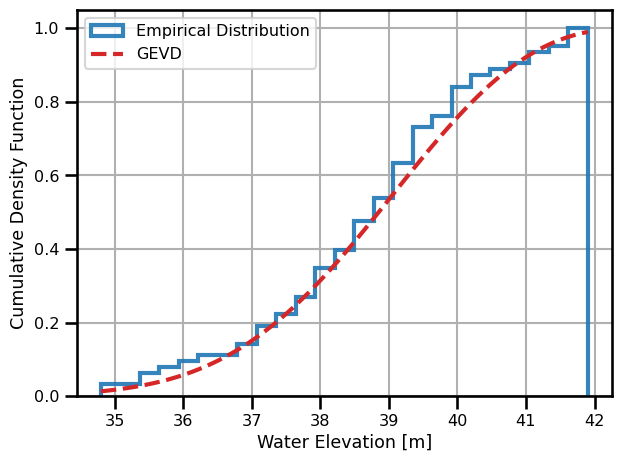

In [36]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=True, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_cdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Water Elevation [m]",
    ylabel="Cumulative Density Function",
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

## Return Period

A major goal of the EVT is to estimate the extreme values corresponding to some return periods.
In other words, we want to know the relationship between the non-exceedence probability and the return periods.
This relationship is given by:

$$
p(X\leq x_T) = \frac{1}{T}
$$

where $x_T$ is the extreme annual water elevation corresponding to the return period of $T$.

**Resources**:
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [37]:
# simple return periods
return_periods = np.logspace(-0.999, 2, 100)
# calculate
return_levels = genextreme.isf(1/return_periods, *params)

In [38]:
return_levels

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 33.44608362, 36.17181326,
       36.84604936, 37.28838552, 37.62705883, 37.9053426 , 38.14349657,
       38.35275804, 38.54005735, 38.7099935 , 38.86578719, 39.00978908,
       39.14377199, 39.26910907, 39.38688773, 39.49798537, 39.60312133,
       39.70289363, 39.79780553, 39.88828508, 39.97469991, 40.05736849,
       40.13656881, 40.21254531, 40.28551427, 40.35566823, 40.42317951,
       40.48820313, 40.5508792 , 40.6113349 , 40.66968617, 40.72603908,
       40.78049101, 40.83313172, 40.88404413, 40.93330512, 40.98

In [39]:
return_periods_ = 1/genextreme.sf(return_levels, *params)
return_periods_

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,   1.00153624,   1.0738895 ,   1.15146973,
         1.23465453,   1.32384879,   1.41948665,   1.52203361,
         1.63198879,   1.74988739,   1.87630325,   2.01185168,
         2.15719244,   2.31303294,   2.48013172,   2.6593021 ,
         2.85141616,   3.05740897,   3.27828317,   3.51511383,
         3.76905368,   4.04133873,   4.33329426,   4.64634133,
         4.98200364,   5.34191496,   5.72782709,   6.14161839,
         6.58530293,   7.06104025,   7.57114591,   8.11

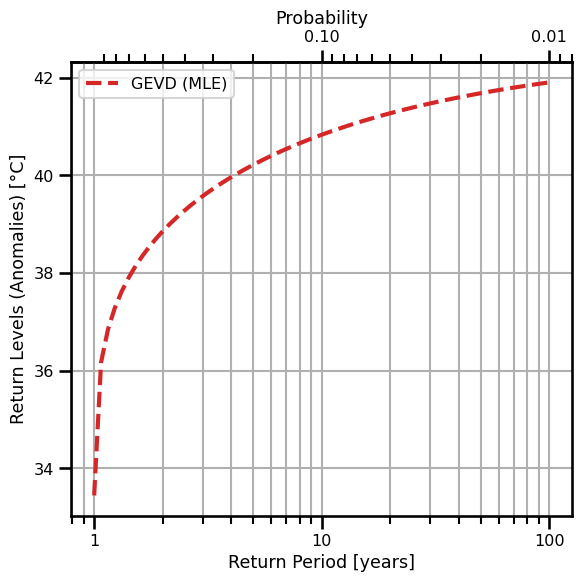

In [41]:


fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (MLE)",
)


ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
)

# SECOND AXIS
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = np.reciprocal(x[~near_zero])
    return x

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()


## Map

In [57]:
ds_sub = ds.t2m.where(ds.t2m - 272.15 > extremes.max()).sum(["latitude", "longitude"]).compute()
ds_sub = ds_sub.where(ds_sub > 0, drop=True)
# ds_sub = ds_sub[ds_sub.argmax()]
ds_sub

<xarray.DataArray 't2m' (time: 1273)> Size: 5kB
array([1570.6719 , 3467.105  ,  314.32986, ..., 2835.1924 , 1256.6821 ,
        316.42584], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 10kB 1959-07-06 1959-07-13 ... 2021-09-07
    region   int64 8B 132
    abbrevs  <U2 8B 'E'
    names    <U8 32B 'Spain'

In [52]:
df = ds.where(ds.spain_mask==1).sel(time="2021-08-14").t2m.to_dataframe()
df = df.dropna()
df

time  region abbrevs  names         t2m
latitude longitude                                              
43.50    -8.25     2021-08-14     132       E  Spain  294.645844
         -8.00     2021-08-14     132       E  Spain  295.764679
         -7.75     2021-08-14     132       E  Spain  296.540619
         -7.50     2021-08-14     132       E  Spain  297.624176
         -7.25     2021-08-14     132       E  Spain  295.852844
...                       ...     ...     ...    ...         ...
36.25    -6.00     2021-08-14     132       E  Spain  304.468445
         -5.75     2021-08-14     132       E  Spain  304.489990
         -5.50     2021-08-14     132       E  Spain  301.447021
         -5.25     2021-08-14     132       E  Spain  298.491211
36.00    -5.50     2021-08-14     132       E  Spain  299.697235

[849 rows x 5 columns]

In [53]:
df["probs"] = genextreme.cdf(df["t2m"], *params)

In [54]:
ds_ = df.to_xarray()

In [55]:
ds_

<xarray.Dataset> Size: 69kB
Dimensions:    (latitude: 31, longitude: 50)
Coordinates:
  * latitude   (latitude) float32 124B 43.5 43.25 43.0 42.75 ... 36.5 36.25 36.0
  * longitude  (longitude) float32 200B -8.25 -8.0 -7.75 -7.5 ... 2.5 2.75 3.0
Data variables:
    time       (latitude, longitude) datetime64[ns] 12kB 2021-08-14 ... NaT
    region     (latitude, longitude) float64 12kB 132.0 132.0 132.0 ... nan nan
    abbrevs    (latitude, longitude) object 12kB 'E' 'E' 'E' 'E' ... nan nan nan
    names      (latitude, longitude) object 12kB 'Spain' 'Spain' ... nan nan
    t2m        (latitude, longitude) float32 6kB 294.6 295.8 296.5 ... nan nan
    probs      (latitude, longitude) float64 12kB 1.0 1.0 1.0 ... nan nan nan

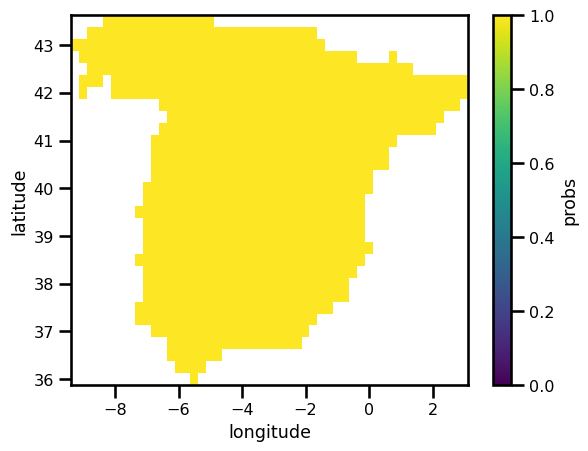

In [56]:
ds_.probs.sortby("longitude").sortby("latitude").plot.pcolormesh(vmin=0.0, vmax=1.0)

In [60]:


return_levels = df["t2m"]
return_periods = genextreme.ppf(return_levels, *params)
return_periods

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [47]:
ds.t2m.isel(time=0).plot.pcolormesh()

<xarray.DataArray 't2m' (spatial: 2501)> Size: 20kB
dask.array<reshape, shape=(2501,), dtype=float64, chunksize=(2501,), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 8B 1959-01-01
    dayofyear  int32 4B dask.array<chunksize=(), meta=np.ndarray>
    region     int64 8B 132
    abbrevs    <U2 8B 'E'
    names      <U8 32B 'Spain'
  * spatial    (spatial) object 20kB MultiIndex
  * latitude   (spatial) float32 10kB 45.0 45.0 45.0 45.0 ... 35.0 35.0 35.0
  * longitude  (spatial) float32 10kB -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0

In [43]:
return_levels

array([nan, nan, nan, ..., nan, nan, nan])